In [21]:
#import some stuff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
from tqdm import tqdm
import glob
import time
import xgboost as xgb
from sklearn.model_selection import train_test_split #use this?
from scipy import stats
from sklearn.metrics import log_loss, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import GridSearchCV

In [2]:
urlScout = 'https://raw.githubusercontent.com/bigdatacup/Big-Data-Cup-2021/main/hackathon_scouting.csv'
urlWomen = 'https://raw.githubusercontent.com/bigdatacup/Big-Data-Cup-2021/main/hackathon_womens.csv'
dataScout = pd.read_csv(urlScout)
dataWomen = pd.read_csv(urlWomen)

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
dataScout.head(1)

,game_date,Home Team,Away Team,Period,Clock,Home Team Skaters,Away Team Skaters,Home Team Goals,Away Team Goals,Team,Player,Event,X Coordinate,Y Coordinate,Detail 1,Detail 2,Detail 3,Detail 4,Player 2,X Coordinate 2,Y Coordinate 2
0,2019-09-20,Erie Otters,Sudbury Wolves,1,20:00,5,5,0,0,Sudbury Wolves,Blake Murray,Faceoff Win,100,43,Forehand,NaN,NaN,NaN,Connor Lockhart,NaN,NaN


In [5]:
a = np.array(dataWomen[['game_date','Home Team','Away Team']]).astype("<U22")
print('There are ',len(np.unique(a,axis=0)),' games in the women dataset')
b = np.array(dataScout[['game_date','Home Team','Away Team']]).astype("<U22")
print('There are ',len(np.unique(b,axis=0)),' games in the scout dataset')

There are  13  games in the women dataset
There are  40  games in the scout dataset


In [6]:
dataWomen.head(1)

,game_date,Home Team,Away Team,Period,Clock,Home Team Skaters,Away Team Skaters,Home Team Goals,Away Team Goals,Team,Player,Event,X Coordinate,Y Coordinate,Detail 1,Detail 2,Detail 3,Detail 4,Player 2,X Coordinate 2,Y Coordinate 2
0,2018-02-11,Olympic (Women) - Canada,Olympic (Women) - Olympic Athletes from Russia,1,20:00,5,5,0,0,Olympic (Women) - Canada,Emily Clark,Faceoff Win,100,42,Backhand,NaN,NaN,NaN,Lyudmila Belyakova,NaN,NaN


In [8]:
print('Amount of Passes for Women:',len(dataWomen.loc[(dataWomen['Event'] ==  'Play' ) | (dataWomen['Event'] == 'Incomplete Play')]))
print('Amount of Shots for Women:',len(dataWomen.loc[(dataWomen['Event'] ==  'Shot' ) | (dataWomen['Event'] == 'Goal')]))
print('Amount of Passes for Scout:',len(dataScout.loc[(dataScout['Event'] ==  'Play' ) | (dataScout['Event'] == 'Incomplete Play')]))
print('Amount of Shots for Scout:',len(dataScout.loc[(dataScout['Event'] ==  'Shot' ) | (dataScout['Event'] == 'Goal')]))

Amount of Passes for Women: 10105
Amount of Shots for Women: 1671
Amount of Passes for Scout: 32668
Amount of Shots for Scout: 5180


In [109]:
def fixDumpsX(row):
    if row['Event'] == 'Dump In/Out':
        if row['NextEvent'] == 'Puck Recovery':
            if row['NextX'] < 75:
                return (200 - row['NextX'])
            else:
                return row['NextX']
        else:
            if row['NextXShift2'] < 75:
                return (200 - row['NextXShift2'])
            else:
                return row['NextXShift2']
    else:
        return row['X Coordinate 2']
    
def fixDumpsY(row):
    if row['Event'] == 'Dump In/Out':
        if row['NextEvent'] == 'Puck Recovery':
            if row['NextX'] < 75:
                return (85 - row['NextY'])
            else:
                return row['NextY']
        else:
            if row['NextXShift2'] < 75:
                return (85 - row['NextYShift2'])
            else:
                return row['NextYShift2']
    else:
        return row['Y Coordinate 2']

def getDataReadySimple(df):
    df = df.copy()
    
    df['NextEvent'] = df['Event'].shift(-1)
    df['NextEvent2'] = df['Event'].shift(-2)
    df['NextX'] = df['X Coordinate'].shift(-1)
    df['NextY'] = df['Y Coordinate'].shift(-1)
    df['NextXShift2'] = df['X Coordinate'].shift(-2)
    df['NextYShift2'] = df['Y Coordinate'].shift(-2)
    #filter out dumps that go to goalie
    df = df.loc[((df['Event'] == 'Dump In/Out') & ((df['NextEvent'] == 'Puck Recovery') | (df['NextEvent2'] == 'Puck Recovery'))) | (df['Event'] != 'Dump In/Out')]
    df['X Coordinate 2'] = df.apply(lambda row: fixDumpsX(row),axis=1)
    df['Y Coordinate 2'] = df.apply(lambda row: fixDumpsY(row),axis=1)
    df['isDump'] = df.apply(lambda row: 1 if (row['Event'] == 'Dump In/Out') else 0,axis=1)
    df['isDumpRetained'] = df.apply(lambda row: (row['Detail 1'] == 'Retained'),axis=1)
    
    filteredDF = df.loc[(df['Event'] ==  'Play' ) | (df['Event'] == 'Incomplete Play') | (df['Event'] == 'Dump In/Out')].copy() #only need these rows
    filteredDF['TeamSkaters'] = filteredDF.apply(lambda row: row['Home Team Skaters'] if (row['Team'] == row['Home Team']) else row['Away Team Skaters'],axis=1)
    filteredDF['OppSkaters'] = filteredDF.apply(lambda row: row['Home Team Skaters'] if (row['Team'] == row['Away Team']) else row['Away Team Skaters'],axis=1)
    filteredDF['onPP'] = filteredDF.apply(lambda row: row['TeamSkaters'] > row['OppSkaters'],axis=1)
    filteredDF['onPK'] = filteredDF.apply(lambda row: row['TeamSkaters'] < row['OppSkaters'],axis=1)
    filteredDF['AmountExtraSkaters'] = filteredDF.apply(lambda row: row['TeamSkaters'] - row['OppSkaters'],axis=1)
    filteredDF['CompletePass'] = filteredDF.apply(lambda row: 1 if (row['Event'] == 'Play') else 0,axis=1)
    filteredDF['CompletePass'] = filteredDF.apply(lambda row: 1 if ((row['isDump'] == 1) & row['isDumpRetained'])
                                                  else row['CompletePass'],axis=1)
    filteredDF['passXTravel'] = filteredDF.apply(lambda row: row['X Coordinate 2'] - row['X Coordinate'],axis=1)
    filteredDF['passYTravel'] = filteredDF.apply(lambda row: row['Y Coordinate 2'] - row['Y Coordinate'],axis=1)
    filteredDF['TotalDistance'] = filteredDF.apply(lambda row: (row['passXTravel']**2 + row['passYTravel']**2)**0.5,axis=1)
    #this is for simple model
    filteredDF = filteredDF[['X Coordinate','Y Coordinate','X Coordinate 2','Y Coordinate 2','onPP','onPK','isDump',
                           'passXTravel','passYTravel','TotalDistance','AmountExtraSkaters','CompletePass']]
    X = filteredDF.iloc[:,:-1]
    y = filteredDF.iloc[:,-1]
    return X,y

In [108]:
def getDataReadyComplex(df):
    df = df.copy()
    df['isFaceOff'] = df['Event'].apply(lambda row: row == 'Faceoff Win')
    df['SecondsLeft'] = df['Clock'].apply(lambda row: float(row.split(':')[0]) * 60 + float(row.split(':')[1]))
    df['ChangeInPoss'] = (df['Team'] != df['Team'].shift(1))
    df['ChangeInPoss'] = df.apply(lambda row: True if (row['Event'] == 'Faceoff Win') else row['ChangeInPoss'],axis=1)
    df = df.rename(columns={'ChangeInPoss':'PossStart'})
    df['PossStartTime'] = df.apply(lambda row: row['SecondsLeft'] if row['PossStart'] else -1.0,axis=1)
    for i in range(len(df)):
        if df.loc[i,'PossStartTime'] == -1.0:
            df.loc[i,'PossStartTime'] = df.loc[i-1,'PossStartTime']
    df['PossTotalTime'] = df.apply(lambda row: row['PossStartTime'] - row['SecondsLeft'],axis=1)
    df = df.drop(columns=['PossStart','PossStartTime']) #drop these cuz I don't think I need them
    
    df['NextEvent'] = df['Event'].shift(-1)
    df['NextEvent2'] = df['Event'].shift(-2)
    df['NextX'] = df['X Coordinate'].shift(-1)
    df['NextY'] = df['Y Coordinate'].shift(-1)
    df['NextXShift2'] = df['X Coordinate'].shift(-2)
    df['NextYShift2'] = df['Y Coordinate'].shift(-2)
    #filter out dumps that go to goalie
    df = df.loc[((df['Event'] == 'Dump In/Out') & ((df['NextEvent'] == 'Puck Recovery') | (df['NextEvent2'] == 'Puck Recovery'))) | (df['Event'] != 'Dump In/Out')]
    df['X Coordinate 2'] = df.apply(lambda row: fixDumpsX(row),axis=1)
    df['Y Coordinate 2'] = df.apply(lambda row: fixDumpsY(row),axis=1)
    df['isDump'] = df.apply(lambda row: 1 if (row['Event'] == 'Dump In/Out') else 0,axis=1)
    df['isDumpRetained'] = df.apply(lambda row: (row['Detail 1'] == 'Retained'),axis=1)
    
    filteredDF = df.loc[(df['Event'] ==  'Play' ) | (df['Event'] == 'Incomplete Play') | (df['Event'] == 'Dump In/Out')].copy() #only need these rows
    filteredDF['TeamSkaters'] = filteredDF.apply(lambda row: row['Home Team Skaters'] if (row['Team'] == row['Home Team']) else row['Away Team Skaters'],axis=1)
    filteredDF['OppSkaters'] = filteredDF.apply(lambda row: row['Home Team Skaters'] if (row['Team'] == row['Away Team']) else row['Away Team Skaters'],axis=1)
    filteredDF['onPP'] = filteredDF.apply(lambda row: row['TeamSkaters'] > row['OppSkaters'],axis=1)
    filteredDF['onPK'] = filteredDF.apply(lambda row: row['TeamSkaters'] < row['OppSkaters'],axis=1)
    filteredDF['AmountExtraSkaters'] = filteredDF.apply(lambda row: row['TeamSkaters'] - row['OppSkaters'],axis=1)
    filteredDF['CompletePass'] = filteredDF.apply(lambda row: 1 if (row['Event'] == 'Play') else 0,axis=1)
    filteredDF['CompletePass'] = filteredDF.apply(lambda row: 1 if ((row['isDump'] == 1) & row['isDumpRetained'])
                                                  else row['CompletePass'],axis=1)
    filteredDF['DirectPass'] = filteredDF.apply(lambda row: 1 if (row['Detail 1'] == 'Direct') else 0,axis=1)
    filteredDF['passXTravel'] = filteredDF.apply(lambda row: row['X Coordinate 2'] - row['X Coordinate'],axis=1)
    filteredDF['passYTravel'] = filteredDF.apply(lambda row: row['Y Coordinate 2'] - row['Y Coordinate'],axis=1)
    filteredDF['TotalDistance'] = filteredDF.apply(lambda row: (row['passXTravel']**2 + row['passYTravel']**2)**0.5,axis=1)
    filteredDF['passAngle'] = filteredDF.apply(lambda row: math.atan2(row['passYTravel'],row['passXTravel']),axis=1)
    filteredDF['GoalsDown'] = filteredDF.apply(lambda row: (row['Home Team Goals'] - row['Away Team Goals'])
                                              if (row['Team'] == row['Away Team Goals'])
                                              else (row['Away Team Goals'] - row['Home Team Goals']),axis=1)
    #this is for complex model
    filteredDF = filteredDF[['Period','SecondsLeft','PossTotalTime','TeamSkaters','OppSkaters','DirectPass','X Coordinate',
                      'Y Coordinate','X Coordinate 2','Y Coordinate 2','passXTravel','passYTravel','TotalDistance','isDump',
                      'passAngle','GoalsDown','onPP','onPK','AmountExtraSkaters','CompletePass']]
    
    X = filteredDF.iloc[:,:-1]
    y = filteredDF.iloc[:,-1]
    return X,y

# Make the complex model

In [80]:
X,y = getDataReadyComplex(dataScout)

In [81]:
print("Overall Mean:", y.mean())
#get train/test split ready

Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=0.25,random_state=24) #can add shuffle=False to not shuffle

#train the xgboost model
dtrain = xgb.DMatrix(Xtrain,label=ytrain)

# XGBoost model
nrounds = 560 #use gridSearchCV
params = {
    'objective': 'binary:logistic',
    'booster' : 'gblinear', #gblinear/gbtree?
    'eval_metric' : ['logloss'],
    'eta' : 0.1,
    'gamma' : 3,
    'subsample' : 0.8,
    'colsample_bytree' : 0.8,
    'max_depth': 6,
    'min_child_weight' : 6,
    'base_score' : ytrain.mean()
}

xcp_model = xgb.train(params, dtrain, num_boost_round=nrounds, verbose_eval=2)
# save for debug
xcp_model.save_model('xCPwithDumpIn_complex.json')

#test the model
dtest = xgb.DMatrix(Xtest,label=ytest)
xgb_predictions = xcp_model.predict(dtest).tolist()
print("XGBoost mean vs actual mean:")
# print(xgb_predictions)
XtestCopy = Xtest.copy()
XtestCopy['xCP'] = xgb_predictions
print(XtestCopy['xCP'].mean())
print(ytest.mean())

#now let's get the errors
#xGList = pd.concat([XtestxGCopy['xG'],ytestxG],axis=1,keys=['xG','Goal'])
#xGList = xGList.sort_values(by=['xG'])
LLerror = log_loss(ytest,xgb_predictions)
RMSerror = mean_squared_error(ytest,xgb_predictions,squared=False)
RMSLerror = mean_squared_log_error(ytest,xgb_predictions)
print("Log loss error is:",LLerror)
print("Root Mean Squared error is:",RMSerror)
print("Root Mean Squared Log error is:",RMSLerror)

Overall Mean: 0.6538769197952219
XGBoost mean vs actual mean:
0.6550697096231721
0.6478242320819113
Log loss error is: 0.5513913499278937
Root Mean Squared error is: 0.43005580640348284
Root Mean Squared Log error is: 0.09111815417155777


# Make the simple model

In [100]:
Xsmall,ysmall = getDataReadySimple(dataScout)

In [101]:
XsmallAug = Xsmall.copy()
XsmallAug['Y Coordinate'] = XsmallAug.apply(lambda row: 85 - row['Y Coordinate'],axis=1)
XsmallAug['Y Coordinate 2'] = XsmallAug.apply(lambda row: 85 - row['Y Coordinate 2'],axis=1)

In [106]:
XsmallConcat = pd.concat([Xsmall,XsmallAug])
ysmallConcat = pd.concat([ysmall,ysmall])

In [107]:
print("Overall Mean:", ysmall.mean())
#get train/test split ready

Xtrainsmall, Xtestsmall, ytrainsmall, ytestsmall = train_test_split(XsmallConcat,ysmallConcat,test_size=0.25,random_state=24) #can add shuffle=False to not shuffle

#train the xgboost model
dtrain = xgb.DMatrix(Xtrainsmall,label=ytrainsmall)

# XGBoost model
nrounds = 560 #use gridSearchCV
params = {
    'objective': 'binary:logistic',
    'booster' : 'gblinear', #gblinear/gbtree?
    'eval_metric' : ['logloss'],
    'eta' : 0.1,
    'gamma' : 3,
    'subsample' : 0.8,
    'colsample_bytree' : 0.8,
    'max_depth': 6,
    'min_child_weight' : 6,
    'base_score' : ytrainsmall.mean()
}

xcpSmall_model = xgb.train(params, dtrain, num_boost_round=nrounds, verbose_eval=2)
# save for debug
#xcpSmall_model.dump_model('xCPSmall_dump.json', with_stats=True, dump_format='json')
xcpSmall_model.save_model('xCPwithDumpInAug_simple.json')

#test the model
dtest = xgb.DMatrix(Xtestsmall,label=ytestsmall)
xgb_predictionssmall = xcpSmall_model.predict(dtest).tolist()
print("XGBoost mean vs actual mean:")
# print(xgb_predictions)
XtestCopysmall = Xtestsmall.copy()
XtestCopysmall['xCP'] = xgb_predictionssmall
print(XtestCopysmall['xCP'].mean())
print(ytestsmall.mean())

#now let's get the errors
xCPListsmall = pd.concat([XtestCopysmall['xCP'],ytestsmall],axis=1,keys=['xCP','CompletePass'])
xCPListsmall = xCPListsmall.sort_values(by=['xCP'])
LLerror = log_loss(ytestsmall,xgb_predictionssmall)
RMSerror = mean_squared_error(ytestsmall,xgb_predictionssmall,squared=False)
RMSLerror = mean_squared_log_error(ytestsmall,xgb_predictionssmall)
print("Log loss error is:",LLerror)
print("Root Mean Squared error is:",RMSerror)
print("Root Mean Squared Log error is:",RMSLerror)

Overall Mean: 0.6538769197952219
XGBoost mean vs actual mean:
0.6565045413726849
0.6560900170648464
Log loss error is: 0.5518996322444023
Root Mean Squared error is: 0.43016933548528424
Root Mean Squared Log error is: 0.09065922346186557


Root Mean Squared Log error is: 5.1513656428825386e-05


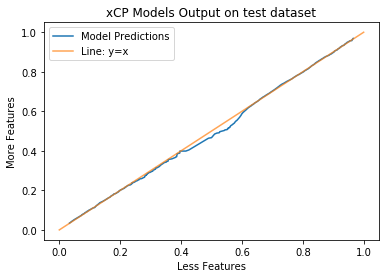

In [89]:
#now let's see how different these two models are
RMSLerror2 =  np.square(np.subtract(xCPListsmall['xCP'].tolist(),xCPList['xCP'].tolist())).mean() #mean_squared_log_error(smallxGList['Goal'].tolist(),smallxGList['xG'].tolist())
print("Root Mean Squared Log error is:",RMSLerror2)
plt.figure()
plt.plot(xCPListsmall['xCP'].tolist(),xCPList['xCP'].tolist(),label='Model Predictions')
plt.plot([0,1],[0,1],label='Line: y=x',alpha = 0.7)
plt.title('xCP Models Output on test dataset')
plt.xlabel('Less Features')
plt.ylabel('More Features')
plt.legend()
plt.show()

# Chart the results to visualize our xCP predictions

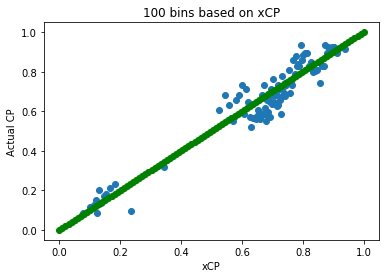

In [83]:
#now let's chart the results
xCPList = pd.concat([XtestCopy['xCP'],ytest],axis=1,keys=['xCP','CompletePass'])

xCPList = xCPList.sort_values(by=['xCP'])
indexList = np.arange(len(xCPList))
[xCPbin_means,CPbin_means], bin_edges, binnumber = stats.binned_statistic(indexList,[xCPList['xCP'], xCPList['CompletePass']],statistic='mean', bins=100)
plt.figure()
#plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=2,label='binned statistic of data')
plt.plot(xCPbin_means,CPbin_means,marker='o',linestyle='none')
x = np.linspace(0,1,num=100)
plt.plot(x,x,color='green',marker='o',linestyle='none')
plt.xlabel('xCP')
plt.ylabel('Actual CP')
plt.title('100 bins based on xCP')
plt.show()

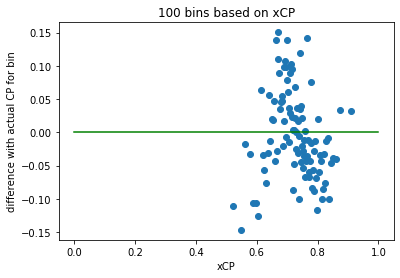

In [13]:
plt.figure()
plt.plot(xCPbin_means,np.subtract(xCPbin_means,CPbin_means),marker='o',linestyle='none')
plt.plot(np.linspace(0,1,num=100),np.zeros(100),color='green')
plt.xlabel('xCP')
plt.ylabel('difference with actual CP for bin')
plt.title('100 bins based on xCP')
plt.show()

In [14]:
binError = np.subtract(xCPbin_means,CPbin_means)
binError = [abs(ele) for ele in binError]
print("average error is:",sum(binError)/len(binError))

average error is: 0.05462574426191322


# Obtain CPOE and RPOE for Otters players

In [15]:
def getCPOEandRPOE(df,xCPdf):
    df = df.copy()
    df = df.loc[(df['Event'] ==  'Play' ) | (df['Event'] == 'Incomplete Play')]
    df = df[['Player','Player 2','Event']]
    df['CompletePass'] = df.apply(lambda row: 1 if (row['Event'] == 'Play') else 0,axis=1)
    df['IncompletePass'] = df.apply(lambda row: 1 if (row['Event'] == 'Incomplete Play') else 0,axis=1)
    df = df.drop(columns=['Event'])
    xCPdf = xCPdf.copy()
    xCPdf = xCPdf[['xCP']]
    merged = xCPdf.merge(df,how='left',left_index=True,right_index=True)
    getCPOE = merged.drop(columns=['Player 2'])
    getRPOE = merged.drop(columns=['Player'])
    CPOE = getCPOE.groupby(by=['Player']).mean()
    CPOE['CPOE'] = CPOE.apply(lambda row: row['CompletePass'] - row['xCP'],axis=1)
    CPOEhelper = getCPOE.groupby(by=['Player']).sum()
    CPOEhelper['TotalPassesThrown'] = CPOEhelper.apply(lambda row: row['CompletePass'] + row['IncompletePass'],axis=1)
    CPOEhelper = CPOEhelper[['TotalPassesThrown']]
    CPOE = CPOE.merge(CPOEhelper,how='left',left_index=True,right_index=True)
    CPOE = CPOE[['CPOE','TotalPassesThrown']] #if you want to see xCP and CompPercentage comment this out
    RPOE = getRPOE.groupby(by=['Player 2']).mean()
    RPOE['RPOE'] = RPOE.apply(lambda row: row['CompletePass'] - row['xCP'],axis=1)
    RPOEhelper = getRPOE.groupby(by=['Player 2']).sum()
    RPOEhelper['TotalPassesReceived'] = RPOEhelper.apply(lambda row: row['CompletePass'] + row['IncompletePass'],axis=1)
    RPOEhelper = RPOEhelper[['TotalPassesReceived']]
    RPOE = RPOE.merge(RPOEhelper,how='left',left_index=True,right_index=True)
    RPOE = RPOE[['RPOE','TotalPassesReceived']] #if you want to see xCP and CompPercentage comment this out
    bothDF = CPOE.merge(RPOE,how='outer',left_index=True,right_index=True)
    return bothDF

In [16]:
bothTest = getCPOEandRPOE(dataScout,XtestCopy)

In [110]:
bothTest.loc[bothTest['TotalPassesReceived'] > 100].sort_values(by='RPOE',ascending=False)

,CPOE,TotalPassesThrown,RPOE,TotalPassesReceived
Jacob Golden,0.056779,248.0,0.104562,173.0
Jamie Drysdale,0.079230,320.0,0.100134,279.0
Drew Hunter,0.056829,237.0,0.081783,156.0
Kurtis Henry,0.010434,276.0,0.081143,183.0
Jack Duff,-0.069372,260.0,0.074186,178.0
Austen Swankler,-0.042686,245.0,0.042857,269.0
Kyen Sopa,0.041957,98.0,0.029624,106.0
Maxim Golod,0.048588,336.0,0.027701,446.0
Emmett Sproule,-0.091596,199.0,0.009249,292.0
Hayden Fowler,-0.103459,228.0,-0.010442,281.0


# Some feature importance stuff I experimented with

[18:31:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Feature:  Period , Score: 0.00819
Feature:  SecondsLeft , Score: 0.01292
Feature:  PossTotalTime , Score: 0.02553
Feature:  TeamSkaters , Score: 0.02255
Feature:  OppSkaters , Score: 0.34334
Feature:  DirectPass , Score: 0.07089
Feature:  X Coordinate , Score: 0.05535
Feature:  Y Coordinate , Score: 0.03425
Feature:  X Coordinate 2 , Score: 0.08952
Feature:  Y Coordinate 2 , Score: 0.06857
Feature:  passXTravel , Score: 0.12675
Feature:  passYTravel , Score: 0.03528
Feature:  TotalDistance , Score: 0.03698
Feature:  passAngle , Score: 0.06366
Feature:  GoalsDown , Score: 0.00622


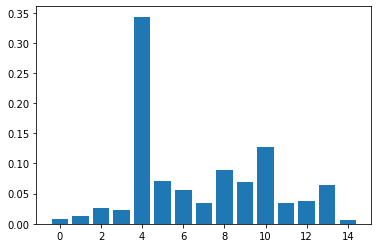

In [29]:
modelCols = X.columns
tstmodel = xgb.XGBRegressor()
tstmodel.fit(X,y)
importance = tstmodel.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: ',modelCols[i], ', Score: %.5f'%v)
# plot feature importance 
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [49]:
#this is just so I remember the code haha

#this will load the model
testLoadModel = xgb.train(params, dtrain, num_boost_round=nrounds, verbose_eval=2)
testLoadModel.load_model('xCP_simple.json')